In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
num_classes = 9
# Load datasets
train_dataset = image_dataset_from_directory(
    os.path.join("kuvat/age/train"),
    image_size=(48, 48),
    batch_size=256
)
validation_dataset = image_dataset_from_directory(
    os.path.join("kuvat/age/val"),
    image_size=(48, 48),
    batch_size=128
)
test_dataset = image_dataset_from_directory(
    os.path.join("kuvat/age/test"),
    image_size=(48, 48),
    batch_size=128
)

# --- Data Augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
])
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Kuvien esikäsittely: skaalataan arvot [0, 1] välille
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
validation_dataset = validation_dataset.map(lambda x, y: (x / 255.0, y))
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))


Found 6802 files belonging to 9 classes.
Found 1419 files belonging to 9 classes.
Found 1555 files belonging to 9 classes.


In [3]:
inputs = keras.Input(shape=(48, 48, 3))
x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,355,017 (12.80 MB)

 Trainable params: 3,355,017 (12.80 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:

callbacks = [
    EarlyStopping(
        patience=5,
        verbose=0,
        restore_best_weights=True,
        monitor="val_loss"
    ),
    ModelCheckpoint(
        filepath="best_age_CNN.keras",
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    )
]

start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
test_loss, test_acc = model.evaluate(test_dataset)

# Save results
np.savez("age_CNN.npz",
         test_acc=test_acc,
         test_loss=test_loss,
         training_time=training_time,
         history=history.history)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.2381 - loss: 2.2256
Epoch 1: val_loss improved from inf to 1.76859, saving model to best_age_CNN.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 432ms/step - accuracy: 0.2402 - loss: 2.2191 - val_accuracy: 0.3813 - val_loss: 1.7686
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.3840 - loss: 1.7292
Epoch 2: val_loss improved from 1.76859 to 1.50706, saving model to best_age_CNN.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 438ms/step - accuracy: 0.3848 - loss: 1.7269 - val_accuracy: 0.4362 - val_loss: 1.5071
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.4310 - loss: 1.5337
Epoch 3: val_loss improved from 1.50706 to 1.40743, saving model to best_age_CNN.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 333ms/step - accuracy: 0.4316 - loss: 1.5327 - val_accuracy: 0.4708 - val_loss: 1.4074
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.4641 - loss: 1.4456
Epoch 4: val_loss improved from 1.40743 to 1.

In [5]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5568 - loss: 1.1110
Test accuracy: 0.5575562715530396


In [6]:
model.save('age_CNN.keras')
print("Model saved as 'age_CNN_model.keras'")

Model saved as 'age_CNN_model.keras'


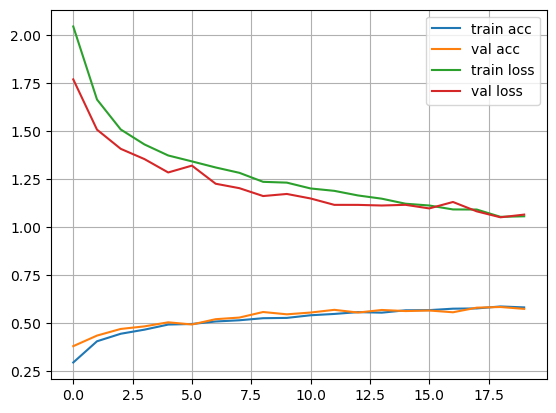

In [7]:
# Assuming you have 'history' from model.fit()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.grid()
plt.show()

In [8]:

# Separate the images and labels into one numpy array
x_test = []
y_test = []

for images, labels in test_dataset:
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

# Combining batches into one large array
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(x_test.shape)
print(y_test.shape)

(1555, 48, 48, 3)
(1555,)


In [9]:

# Ennustetaan kaikki testikuvat
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

names = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]

# Alustetaan oikein
class_correct = [0 for _ in range(len(names))]
class_total = [0 for _ in range(len(names))]

# Lasketaan tarkkuus joka luokalle
for true_label, pred_label in zip(y_test, y_pred_labels):
    class_total[true_label] += 1
    if true_label == pred_label:
        class_correct[true_label] += 1

# Tulostetaan tulokset
for i in range(len(names)):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Accuracy of %5s : %2d %%' % (names[i], accuracy))
    else:
        print('No samples for class', names[i])


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Accuracy of   0-9 : 89 %
Accuracy of 10-19 : 55 %
Accuracy of 20-29 : 69 %
Accuracy of 30-39 : 28 %
Accuracy of 40-49 :  6 %
Accuracy of 50-59 : 40 %
Accuracy of 60-69 : 10 %
Accuracy of 70-79 : 10 %
Accuracy of   80+ : 66 %


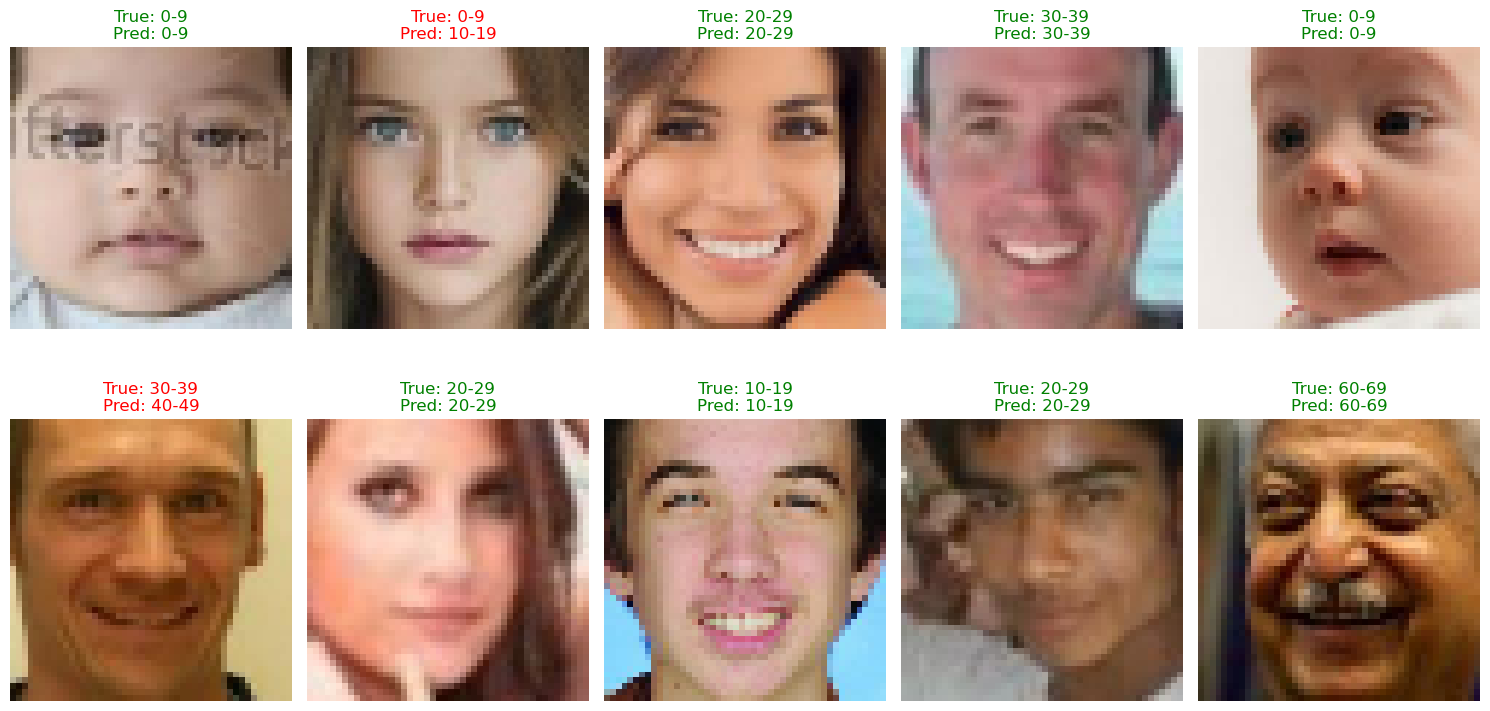

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize a few test images with true and predicted labels
def visualize_predictions(start=0, num_images=10):
    plt.figure(figsize=(15, 8))

    for i in range(num_images):
        plt.subplot(2, 5, i+1)  # 2 rows, 5 images per row
        img = x_test[start + i]
        img = np.clip(img, 0.0, 1.0)  # Ensure values are between 0 and 1
        plt.imshow(img)  # Display the image
        plt.axis('off')

        true_label = names[y_test[start + i]]  # True label
        pred_label = names[y_pred_labels[start + i]]  # Predicted label

        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

    plt.tight_layout()
    plt.show()

# Visualize first 10 images from the test set
visualize_predictions(start=0, num_images=10)

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each class
class_f1_scores = {}
for i, class_name in enumerate(names):
    true_class_indices = (y_test == i)
    pred_class_indices = (y_pred_labels == i)

    precision = precision_score(y_test, y_pred_labels, labels=[i], average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred_labels, labels=[i], average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred_labels, labels=[i], average='macro', zero_division=0)

    class_f1_scores[class_name] = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# Print header
print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print("-" * 40)

# Each class's scores
for class_name, scores in class_f1_scores.items():
    print(f"{class_name:<10} {scores['precision']:<10.2f} {scores['recall']:<10.2f} {scores['f1_score']:<10.2f}")

Class      Precision  Recall     F1 Score  
----------------------------------------
0-9        0.91       0.89       0.90      
10-19      0.43       0.56       0.49      
20-29      0.49       0.70       0.58      
30-39      0.36       0.28       0.32      
40-49      0.40       0.07       0.12      
50-59      0.31       0.41       0.35      
60-69      0.24       0.11       0.15      
70-79      0.23       0.10       0.14      
80+        0.46       0.66       0.54      
